<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_3/notebooks/operator_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Operator Learning

This notebook provides an exemplary implementation of operator learning. In the application below, we will train a DeepONet to predict the trajectories of a chemical reaction network, i.e., how chemical abundances evolve over time given the initial abundances at some time t=0. The data was generated by numerically solving the coupled ordinary differential equations (ODEs) that describe the reaction network. For more information on the data, refer to e.g. [this paper](https://arxiv.org/abs/2312.06015).

This tutorial was originally done by Robin Janssen. Thanks for that!

In [1]:
# First, lets import some stuff

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import copy

In [2]:
# Define the DeepONet architecture

class DeepONet(nn.Module):
    def __init__(self, branch_input_size, trunk_input_size, hidden_size, output_size, branch_hidden_layers, trunk_hidden_layers, n_chemicals, activation=nn.ReLU, device='cpu'):
        super(DeepONet, self).__init__()

        # Define branch network
        self.branch_net = self.create_branch_net(branch_input_size, hidden_size, output_size, branch_hidden_layers, activation).to(device)

        # Define trunk network
        self.trunk_net = self.create_trunk_net(trunk_input_size, hidden_size, output_size, trunk_hidden_layers, activation).to(device)

        self.device = device
        self.n_chemicals = n_chemicals  # Number of chemicals
        self.outputs = output_size  # Total number of neurons in the output layers (branch/trunk)
        self.losses = []

    def create_branch_net(self, input_size, hidden_size, output_size, num_hidden_layers, activation):
        '''
        This is the branch network. It takes the abundances as input and retuns a latent representation.

        '''
        layers = [nn.Linear(input_size, hidden_size), activation()]
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), activation()]
        layers.append(nn.Linear(hidden_size, output_size))
        return nn.Sequential(*layers)

    def create_trunk_net(self, input_size, hidden_size, output_size, num_hidden_layers, activation):
        '''
        This is the trunk network. It takes the coordinates as input and retuns a latent representation.'''

        layers = [nn.Linear(input_size, hidden_size), activation()]
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), activation()]
        layers.append(nn.Linear(hidden_size, output_size))
        return nn.Sequential(*layers)

    def _calculate_split_sizes(self, total_neurons, num_splits):
        """Helper function to calculate split sizes for even distribution"""
        base_size = total_neurons // num_splits
        remainder = total_neurons % num_splits
        return [base_size + 1 if i < remainder else base_size for i in range(num_splits)]

    # Define forward pass
    def forward(self, branch_input, trunk_input):
        '''
        This is the forward pass of the DeepONet. It returns a split scalar product of the branch and trunk networks.
        '''
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)

        # Split the outputs for multiple chemicals
        split_sizes = self._calculate_split_sizes(self.outputs, self.n_chemicals)
        branch_splits = torch.split(branch_output, split_sizes, dim=1)
        trunk_splits = torch.split(trunk_output, split_sizes, dim=1)

        result = []
        for b_split, t_split in zip(branch_splits, trunk_splits):
            result.append(torch.sum(b_split * t_split, dim=1, keepdim=True))

        return torch.cat(result, dim=1)

In [3]:
# Training loop
def train_deeponet(model, train_loader, test_loader, n_epochs, optimizer, criterion, device='cpu'):
    model.train()

    print('Training DeepONet...')
    progress_bar = tqdm.tqdm(range(n_epochs))
    for epoch in progress_bar:
        total_loss = 0

        for batch in train_loader:
            branch_input, trunk_input, targets = batch
            branch_input, trunk_input, targets = branch_input.to(device), trunk_input.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(branch_input, trunk_input)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Make a copy of the model after one epoch
        # This will be used later to visualise the learning process
        if epoch == 0:
            model_copy = copy.deepcopy(model)

        avg_train_loss = total_loss / len(train_loader)
        model.losses.append(avg_train_loss)
        if test_loader is not None:
            val_loss = evaluate_deeponet(model, test_loader, criterion, device)
        progress_bar.set_description(f'Epoch {epoch + 1}/{n_epochs}, Loss: {avg_train_loss:.2e}, Val Loss: {val_loss:.2e}')

    return model_copy


# Evaluation function for the model
def evaluate_deeponet(model, val_loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            branch_input, trunk_input, targets = batch
            branch_input, trunk_input, targets = branch_input.to(device), trunk_input.to(device), targets.to(device)
            outputs = model(branch_input, trunk_input)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_loader)
    return avg_val_loss

In [4]:
# Prediction function for unseen data
def predict_deeponet(model, test_loader, device='cpu', n_timesteps=100, n_chemicals=29):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in test_loader:
            branch_input, trunk_input, target = batch
            branch_input, trunk_input, target = branch_input.to(device), trunk_input.to(device), target.to(device)
            output = model(branch_input, trunk_input)
            predictions.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())

    preds = np.concatenate(predictions).reshape(-1, n_timesteps, n_chemicals)
    targs = np.concatenate(targets).reshape(-1, n_timesteps, n_chemicals)
    return preds, targs

In [5]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [6]:
# Function to create dataloader
def create_dataloader(data, timesteps, batch_size, shuffle=False, device='cpu'):
    branch_inputs = []
    trunk_inputs = []
    targets = []

    data = np.log10(data)  # Log-transform data
    mean = np.mean(data)
    std = np.std(data)
    data = (data - mean) / std  # Standardize data

    # Create inputs from data (branch and trunk inputs)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            branch_inputs.append(data[i, 0, :])  # branch input stays the same (initial condition)
            trunk_inputs.append([timesteps[j]])  # trunk input varies with timesteps
            targets.append(data[i, j, :])  # true values at timestep

    # Convert to tensors
    branch_inputs_tensor = torch.tensor(np.array(branch_inputs), dtype=torch.float32).to(device)
    trunk_inputs_tensor = torch.tensor(np.array(trunk_inputs), dtype=torch.float32).to(device)
    targets_tensor = torch.tensor(np.array(targets), dtype=torch.float32).to(device)

    # Create dataset and dataloader
    dataset = TensorDataset(branch_inputs_tensor, trunk_inputs_tensor, targets_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle), mean, std

# Function to denormalize data (predictions of DeepONet will be standardized and in log-space and hence need to be transformed back)
def denormalize(data, mean, std):
    data = data * std + mean
    data = 10 ** data
    return data

Let's grab the data from heibox...

In [10]:
from urllib import request
import os

# create local folder
if os.path.isdir("./data/") == False:
    os.mkdir("./data/")

urls = ["https://heibox.uni-heidelberg.de/f/fe8f27a7fe9747c5a8b4/?dl=1",
        "https://heibox.uni-heidelberg.de/f/f28c9e2873ae4707a883/?dl=1",
        "https://heibox.uni-heidelberg.de/f/9811b7096b514385b5cc/?dl=1",
        "https://heibox.uni-heidelberg.de/f/d1c3250aaa5147d2b17d/?dl=1"]

target_paths = ["./data/labels.npy", "./data/test.npy", "./data/train.npy", "./data/val.npy"]

# https://docs.python.org/3/library/urllib.request.html#urllib.request.Request
# NOTE: Transfer-Encoding: chunked (streaming) will be auto-selected
for url, target_path in zip(urls, target_paths):  # download data
    with request.urlopen(request.Request(url), timeout=15.0) as response:
        if response.status == 200:
            with open(target_path, "wb") as f:
                f.write(response.read())


In [11]:
# Load data
n_timesteps = 100
data_train = np.load('./data/train.npy')
data_val = np.load('./data/test.npy')
data_test = np.load('./data/val.npy')
labels = np.load('./data/labels.npy', allow_pickle=True)
timesteps = np.linspace(0, 1, n_timesteps)
batch_size = 32
n_chemicals = data_train.shape[2]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create dataloaders
train_loader, mean, std = create_dataloader(data_train[:200], timesteps, batch_size, shuffle=True, device=device)
val_loader, _, _ = create_dataloader(data_val, timesteps, batch_size, shuffle=False, device=device)
test_loader, _, _ = create_dataloader(data_test, timesteps, batch_size, shuffle=False, device=device)

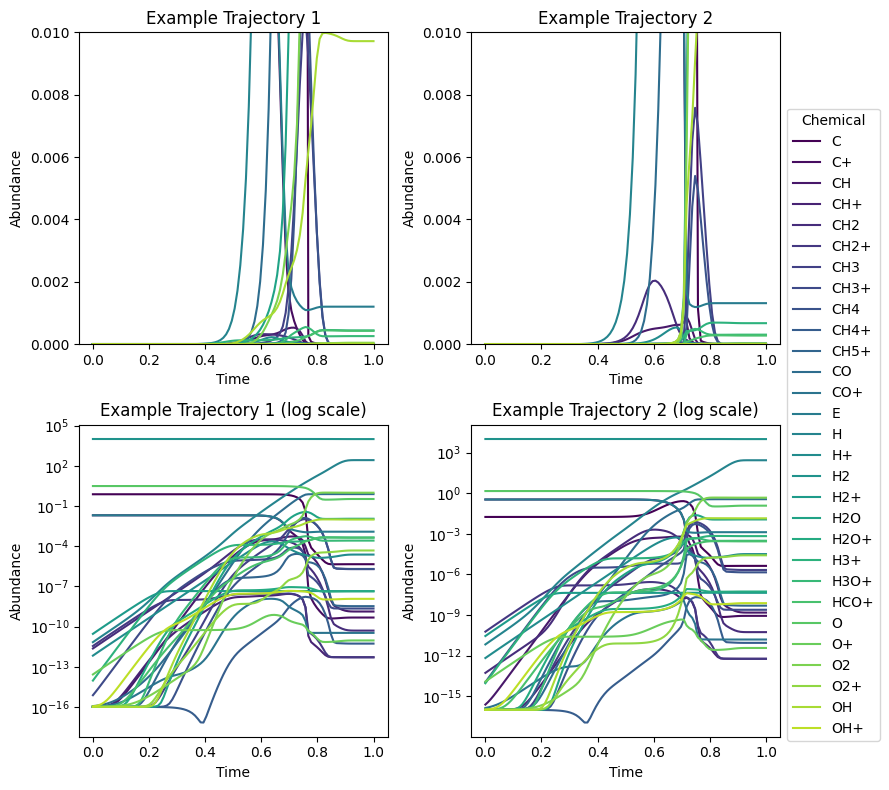

In [12]:
# Plot some data

def plot_example_trajectories(data, timesteps, labels):
    num_quantities = data.shape[2]

     # Define the color palette
    colors = plt.cm.viridis(np.linspace(0, 0.9, num_quantities))

    # Plot the data with a common legend next to the plot

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))

    for i in range(2):
        for j in range(data.shape[2]):
            # The first row show the first two samples
            ax[0, i].plot(timesteps, data[i, :, j], color=colors[j], label=labels[j])
            ax[0, i].set_xlabel('Time')
            ax[0, i].set_ylabel('Abundance')
            ax[0, i].set_title(f'Example Trajectory {i + 1}')
            ax[0, i].set_ylim([0, 1e-2])
            # The second row shows the same data in log scale
            ax[1, i].plot(timesteps, data[i, :, j], color=colors[j], label=labels[j])
            ax[1, i].set_yscale('log')
            ax[1, i].set_xlabel('Time')
            ax[1, i].set_ylabel('Abundance')
            # ax[1, i].set_ylim([1e-8, 1e3])
            ax[1, i].set_title(f'Example Trajectory {i + 1} (log scale)')

    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 1), title='Chemical')
    plt.show()


plot_example_trajectories(data_train, timesteps, labels)

In [13]:
#Hyperparameters
hidden_size = 150
output_size = 1160
branch_hidden_layers = 4
trunk_hidden_layers = 7
n_epochs = 25
learning_rate = 1e-4

# Initialize model
model = DeepONet(branch_input_size=n_chemicals, trunk_input_size=1, hidden_size=hidden_size,
                 output_size=output_size, branch_hidden_layers=branch_hidden_layers, trunk_hidden_layers=trunk_hidden_layers,
                 n_chemicals=n_chemicals, device=device).to(device)


# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
one_epoch_model = train_deeponet(model, train_loader, val_loader, n_epochs, optimizer, criterion, device)

Training DeepONet...


Epoch 25/25, Loss: 4.13e-04, Val Loss: 3.76e-04: 100%|██████████| 25/25 [05:50<00:00, 14.02s/it]


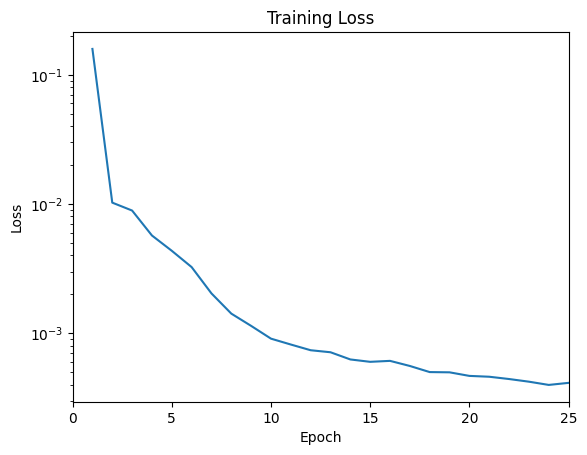

In [15]:
# Plot the loss trajectory

def plot_loss(model):
    plt.plot(np.arange(n_epochs)+1, model.losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.yscale('log')
    plt.xlim([0, n_epochs])
    plt.show()

plot_loss(model)

In [16]:
# Define a big plotting function to visualize the predictions of the model

def plot_predictions_vs_ground_truth(timesteps, predictions, ground_truth, labels, epoch, loss):
    num_quantities = predictions.shape[2]  # Total number of chemical trajectories (29 in this case)
    num_plots = 4  # Four subplots
    num_quantities_per_plot = num_quantities // num_plots  # Number of chemicals per subplot

    # Define the color palette
    colors = plt.cm.viridis(np.linspace(0, 0.9, num_quantities_per_plot))

    # Create subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    for plot_idx in range(num_plots):
        # Determine the subplot's row and column indices
        row_idx = plot_idx // 2
        col_idx = plot_idx % 2

        # Extract the corresponding portion of predictions and ground truth for this subplot
        start_idx = plot_idx * num_quantities_per_plot
        end_idx = start_idx + num_quantities_per_plot

        for j in range(start_idx, end_idx):
            chemical_idx = j - start_idx  # Chemical index relative to this subplot

            # Plot predictions as solid lines
            ax[row_idx, col_idx].plot(timesteps, predictions[0, :, j], color=colors[chemical_idx], linestyle='-', label=f'{labels[j]} (Prediction)')

            # Plot ground truth as dashed lines
            ax[row_idx, col_idx].plot(timesteps, ground_truth[0, :, j], color=colors[chemical_idx], linestyle='--', label=f'{labels[j]} (Ground Truth)')

            ax[row_idx, col_idx].set_xlabel('Time')
            ax[row_idx, col_idx].set_ylabel('Abundance')
            ax[row_idx, col_idx].set_yscale('log')  # Set y-axis to log scale
            ax[row_idx, col_idx].set_title(f'Comparison for Chemicals {start_idx + 1} to {end_idx}')
            ax[row_idx, col_idx].set_ylim([1e-15, 1e5])

        # Set individual legends for each plot
        ax[row_idx, col_idx].legend(loc='best', title='Chemicals')

    plt.suptitle(f'Predictions vs. Ground Truth (Epoch {epoch}, Loss: {loss:.2e})')
    plt.tight_layout()
    plt.show()

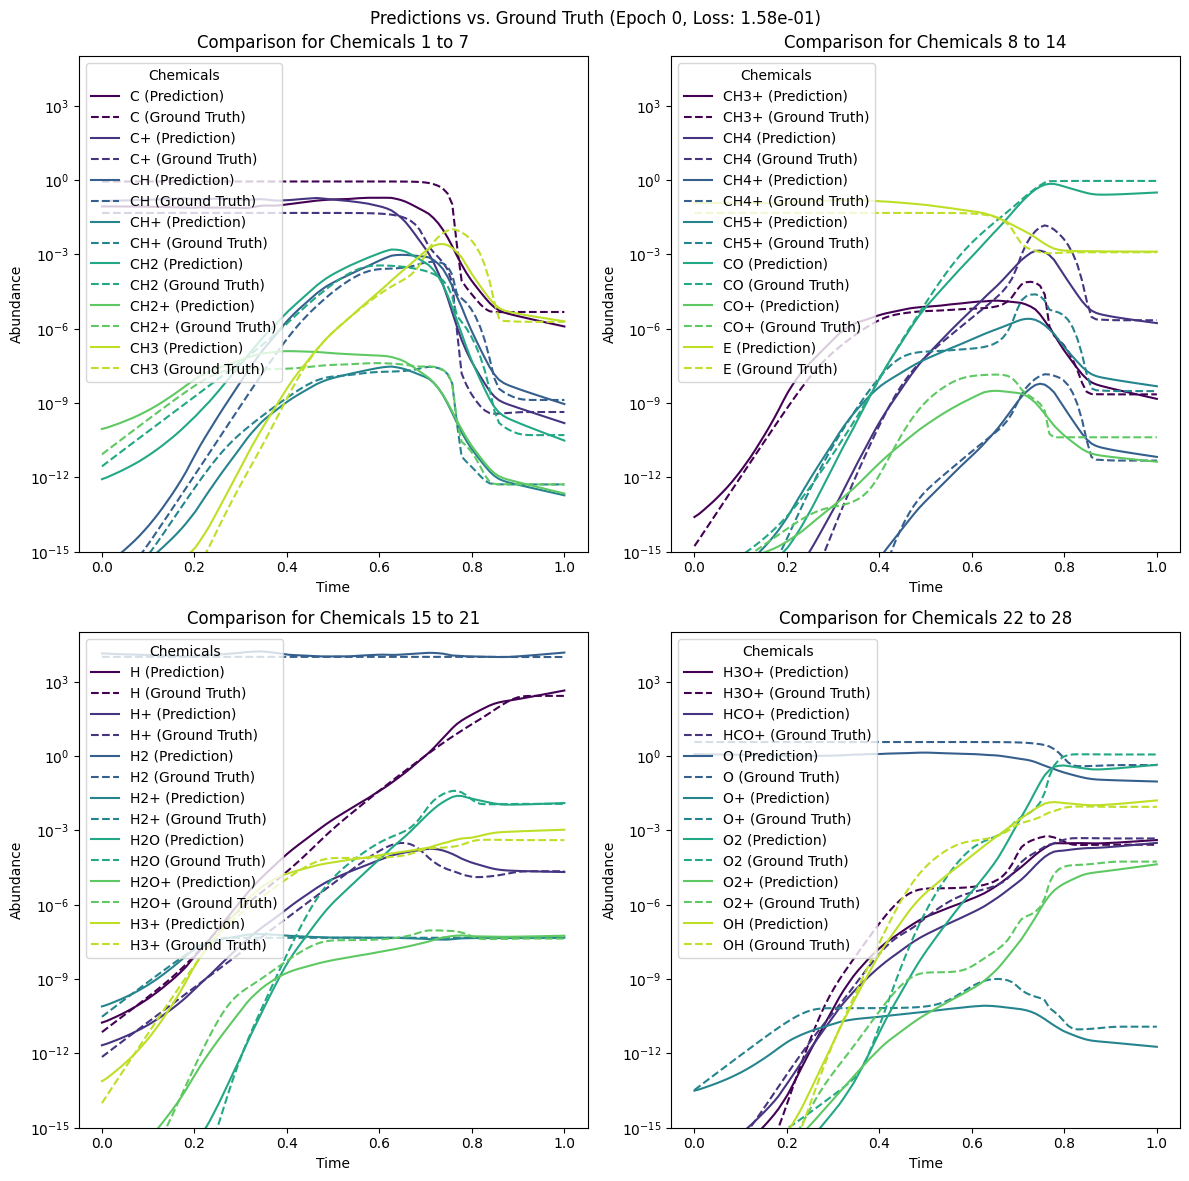

In [17]:
# Use the one-epoch model to predict on the test set
preds_1e, targets_1e = predict_deeponet(one_epoch_model, test_loader, device)

# Denormalize data
preds_1e = denormalize(preds_1e, mean, std)
targets_1e = denormalize(targets_1e, mean, std)

# Plot predictions
plot_predictions_vs_ground_truth(timesteps, preds_1e, targets_1e, labels, epoch=0, loss=model.losses[0])

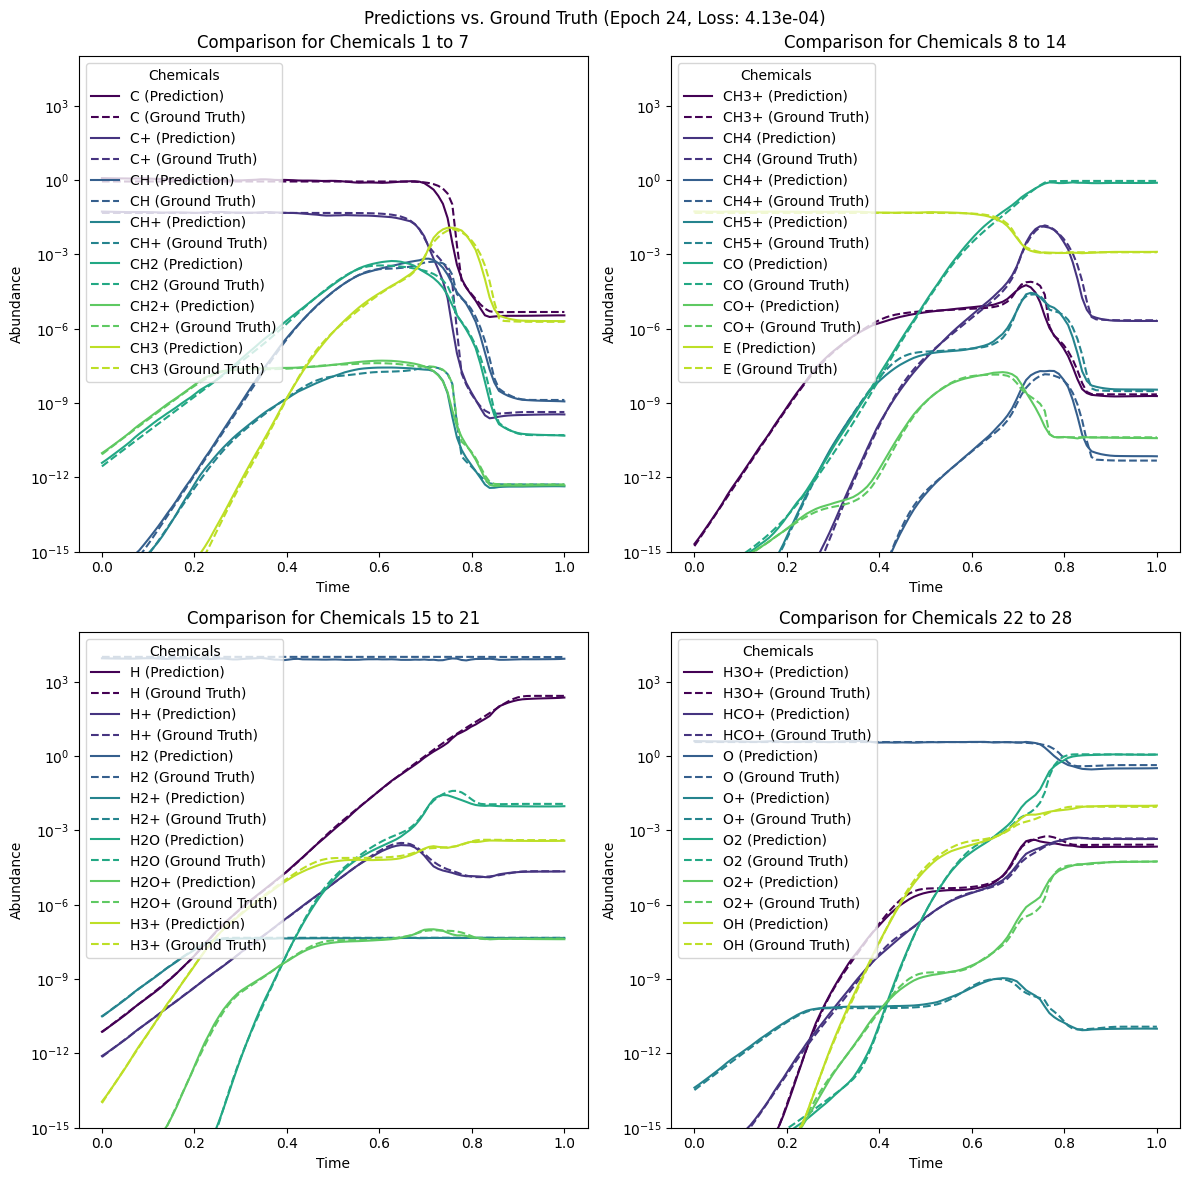

In [18]:
# Now, use the final model to predict on the test set
predictions, targets = predict_deeponet(model, test_loader, device)

# Denormalize predictions and targets
predictions = denormalize(predictions, mean, std)
targets = denormalize(targets, mean, std)

# Plot predictions vs ground truth
plot_predictions_vs_ground_truth(timesteps, predictions, targets, labels, epoch = n_epochs-1, loss=model.losses[-1])